# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.signal import savgol_filter

In [2]:
%matplotlib inline

# Read Data

In [3]:
# Grab all filenames from cwd
*_, filenames = next(os.walk(os.getcwd()))

# Filter for only .csv files
filenames = list(filter(lambda x: x.find('.csv') != -1, filenames))

# Get file names only (removing .csv)
files = [file[:-4] for file in filenames]

# Read data to dictionary
data = {files[i]: pd.read_csv(filenames[i]) for i in range(len(files))}

# Tables

In [4]:
age = data['case_demographics_age']

In [5]:
bed_surge = data['bed_surge']

In [6]:
hospitals = data['new_hospitals_by_county']

In [7]:
ppe = data['logistics_ppe']

In [8]:
cases = data['statewide_cases']

In [9]:
testing = data['statewide_testing']

# Helper Functions

In [10]:
def reduce_ticks(ax, N = 4, axis = 'x'):
    """
    Takes in an Axes object and reduces the number of ticks by every Nth
    """
    if axis == 'x':
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % N != 0:
                label.set_visible(False)
    else:
        for n, label in enumerate(ax.yaxis.get_ticklabels()):
            if n % N != 0:
                label.set_visible(False)
    

# Age Analysis

### Sanity Checks

In [133]:
age.shape

(570, 7)

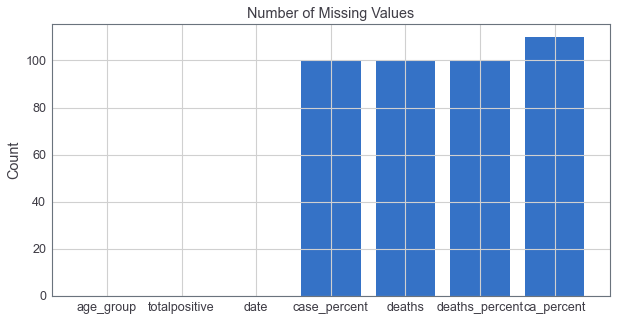

In [27]:
plt.figure(figsize = [10,5])
plt.bar(x = age.columns, height = age.isna().sum())
plt.title("Number of Missing Values")
plt.ylabel('Count')
plt.savefig('age_sanitycheck0')
plt.show()

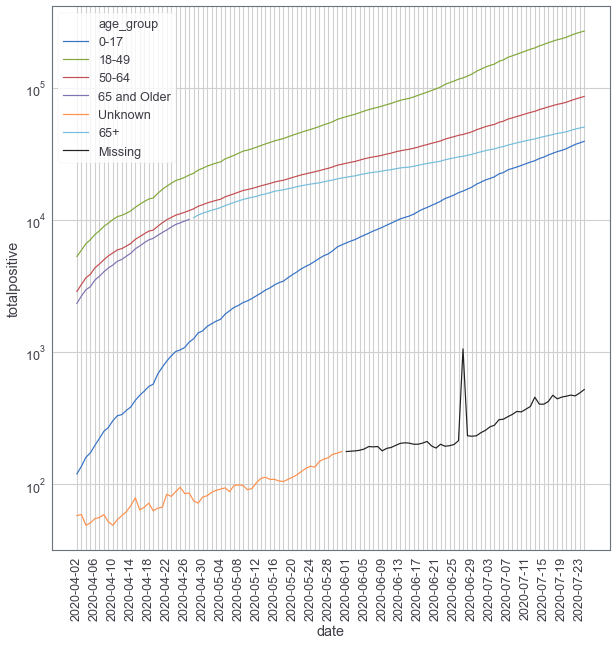

In [12]:
plt.figure(figsize = [10,10])
ax = sns.lineplot(x = 'date', y = 'totalpositive', hue = 'age_group', data = age)
reduce_ticks(ax)
plt.yscale('log')
plt.xticks(rotation = 90)
plt.savefig('age_sanitycheck1')
plt.show()

In [13]:
print(age.age_group.unique())
print(age.age_group.isna().sum())

['0-17' '18-49' '50-64' '65 and Older' 'Unknown' '65+' 'Missing']
0


We see here that unkown and missing are the same. 65+ and 65 and older are also the same. We also know that there are no missing values.

In [14]:
# Unify 65+ and 65 And Older to just 65+
age['age_group'].replace('65 and Older', '65+', inplace = True)
# Change all Unknown to Missing
age['age_group'].replace('Unknown', 'Missing', inplace = True)

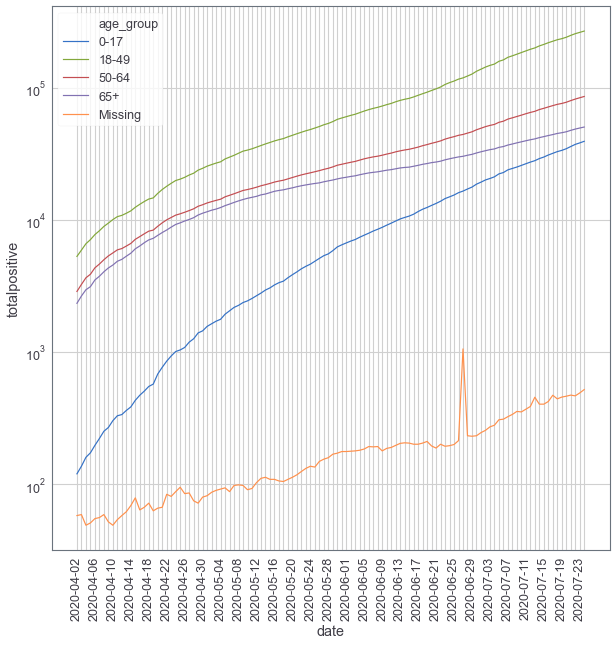

In [16]:
# Plot same as above again
plt.figure(figsize = [10,10])
ax = sns.lineplot(x = 'date', y = 'totalpositive', hue = 'age_group', data = age)
reduce_ticks(ax)
plt.yscale('log')
plt.xticks(rotation = 90)
plt.savefig('age_sanitycheck2')
plt.show()

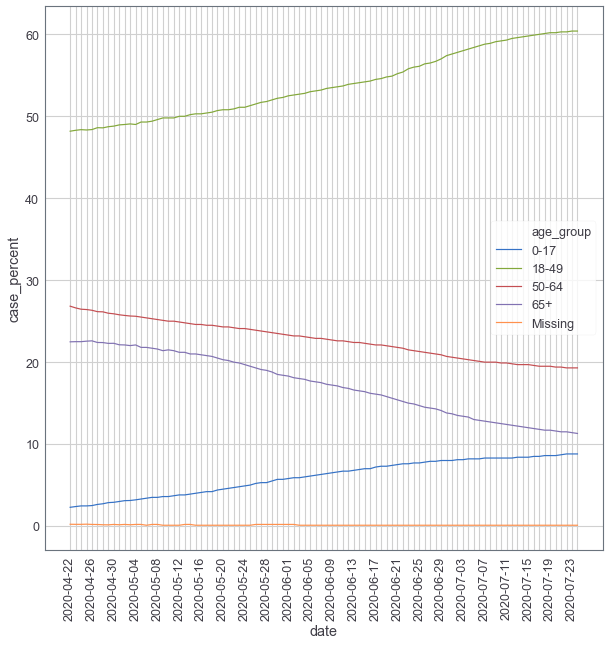

In [17]:
plt.figure(figsize = [10,10])
ax = sns.lineplot(x = 'date', y = 'case_percent', hue = 'age_group', data = age)
reduce_ticks(ax)
plt.xticks(rotation = 90)
plt.show()

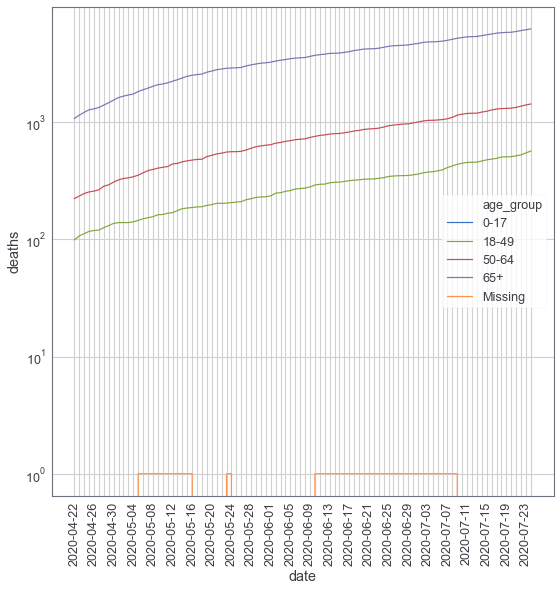

In [18]:
plt.figure(figsize = [9,9])
ax = sns.lineplot(x = 'date', y = 'deaths', hue = 'age_group', data = age)
reduce_ticks(ax)
plt.xticks(rotation = 90)
plt.yscale('log')
plt.show()

In [19]:
age[age.age_group == '0-17']['deaths'].describe()

count    94.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: deaths, dtype: float64

There are no deaths in the 0-17 age group.

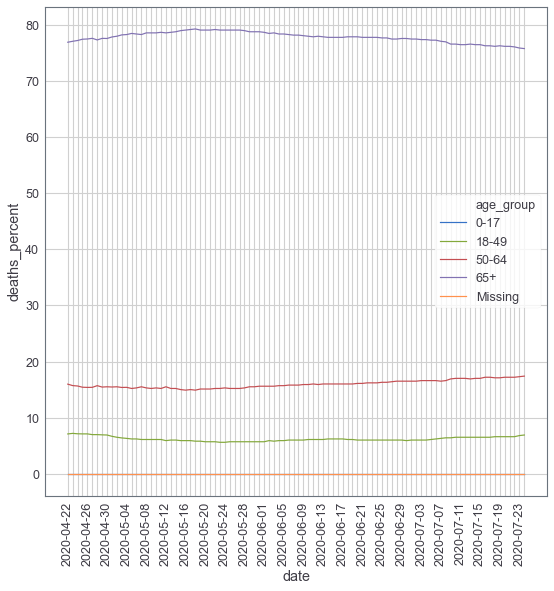

In [20]:
plt.figure(figsize = [9,9])
ax = sns.lineplot(x = 'date', y = 'deaths_percent', hue = 'age_group', data = age)
reduce_ticks(ax)
plt.xticks(rotation = 90)
plt.show()

In [29]:
age.groupby('age_group').deaths_percent.describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
0-17,94.0,0.000000,0.000000,0.0,0.0000,0.000,0.0,0.00
18-49,94.0,6.192766,0.399538,5.6,5.9250,6.100,6.5,7.19
50-64,94.0,15.956596,0.690757,14.9,15.3925,15.850,16.5,17.40
65+,94.0,77.842021,0.914630,75.8,77.3550,77.835,78.6,79.30
Missing,94.0,0.000000,0.000000,0.0,0.0000,0.000,0.0,0.00


The CA percent column represents what percent of the population is represented in the age group. We can see slight shifts in numbers (most notably in 65+). For ease of calculation, I'll assume that the age ratio does not significantly change over time and will use the mean values as the constant.

"Missing" data adds little to the plot as we are examining the effect of COVID-19 on age. For all future analyses, age will be removed.

In [28]:
filtered_age = age[~(age.age_group == 'Missing')]
filtered_age = filtered_age.dropna()

The data is quite clean overall and minimal work was needed to make it useable.

## Exploratory Data Analysis

First, I want to utilize the CA percent column to normalize all the values. This will better represent the growth rates and other differences in the data.

In [30]:
def plot_by_age(df, age_group, color = None):
    """
    Takes in a DF with 'age_group' column of 0-17, 18-49, 50-64, and 65+
    """
    if color != None:
        return plt.plot(df[df['age_group'] == age_group]['date'], df[df['age_group'] == age_group].case_percent)
    else:
        return plt.plot(df[df['age_group'] == age_group]['date'], df[df['age_group'] == age_group].case_percent, color = color)

In [31]:
def normalize_case_percent(df):
    if df['age_group'].all() == '0-17':
        return df['case_percent'] - 22.5
    if df['age_group'].all() == '18-49':
        return df['case_percent'] - 43.5
    if df['age_group'].all() == '50-64':
        return df['case_percent'] - 18.4
    if df['age_group'].all() == '65+':
        return df['case_percent'] - 15.59

In [32]:
case_percent_normalized = filtered_age.groupby('age_group').apply(normalize_case_percent)

In [33]:
filtered_age['case_percent_normalized'] = case_percent_normalized.reset_index(level = 0, drop = True)

In [34]:
filtered_age[filtered_age['date'] == '2020-05-31']

,age_group,totalpositive,date,case_percent,deaths,deaths_percent,ca_percent,case_percent_normalized
320,0-17,6488,2020-05-31,5.7,0.0,0.0,22.5,-16.80
321,18-49,59144,2020-05-31,52.3,231.0,5.7,43.5,8.80
322,50-64,26405,2020-05-31,23.4,636.0,15.6,18.4,5.00
323,65+,20792,2020-05-31,18.4,3213.0,78.8,15.6,2.81


In [35]:
age_groups = ['0-17','18-49','50-64','65+']
colors = ['#db5f57','#dbc257','#91db57','#57db80']
lines = [22.5, 43.5,18.4,15.59]

In [134]:
filtered_age.head(1)

,age_group,totalpositive,date,case_percent,deaths,deaths_percent,ca_percent,case_percent_normalized
100,0-17,855,2020-04-22,2.29,0.0,0.0,22.49,-20.21


<Figure size 432x288 with 0 Axes>

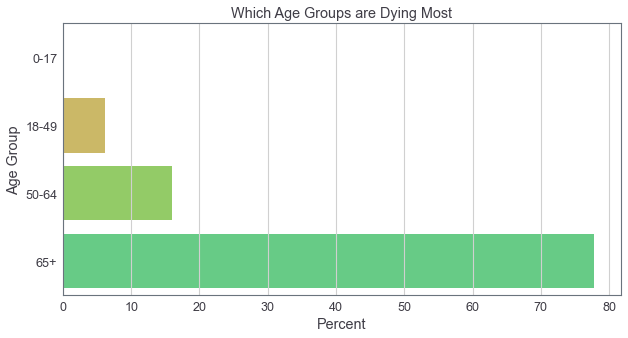

In [174]:
plt.clf()
plt.figure(figsize=[10,5])
ax = sns.barplot(y = 'age_group', x ='deaths_percent', data = filtered_age, hue_order = colors, ci = None)
plt.xlabel('Percent')
plt.ylabel('Age Group')
plt.title('Which Age Groups are Dying Most')
plt.savefig('age_deaths')
plt.show()

<Figure size 432x288 with 0 Axes>

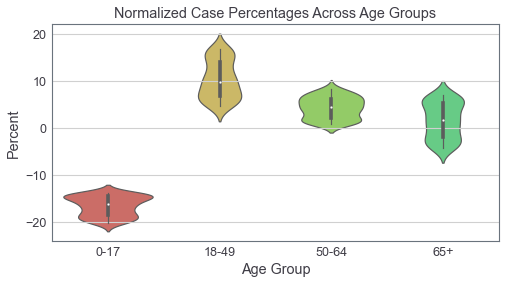

In [193]:
plt.clf()
plt.figure(figsize=[8,4])
ax = sns.violinplot(x = 'age_group', y ='case_percent_normalized', data = filtered_age, inner = 'box', hue_order = colors)
plt.xlabel('Age Group')
plt.ylabel('Percent')
plt.title('Normalized Case Percentages Across Age Groups')
plt.savefig('violin_age_representation')
plt.show()

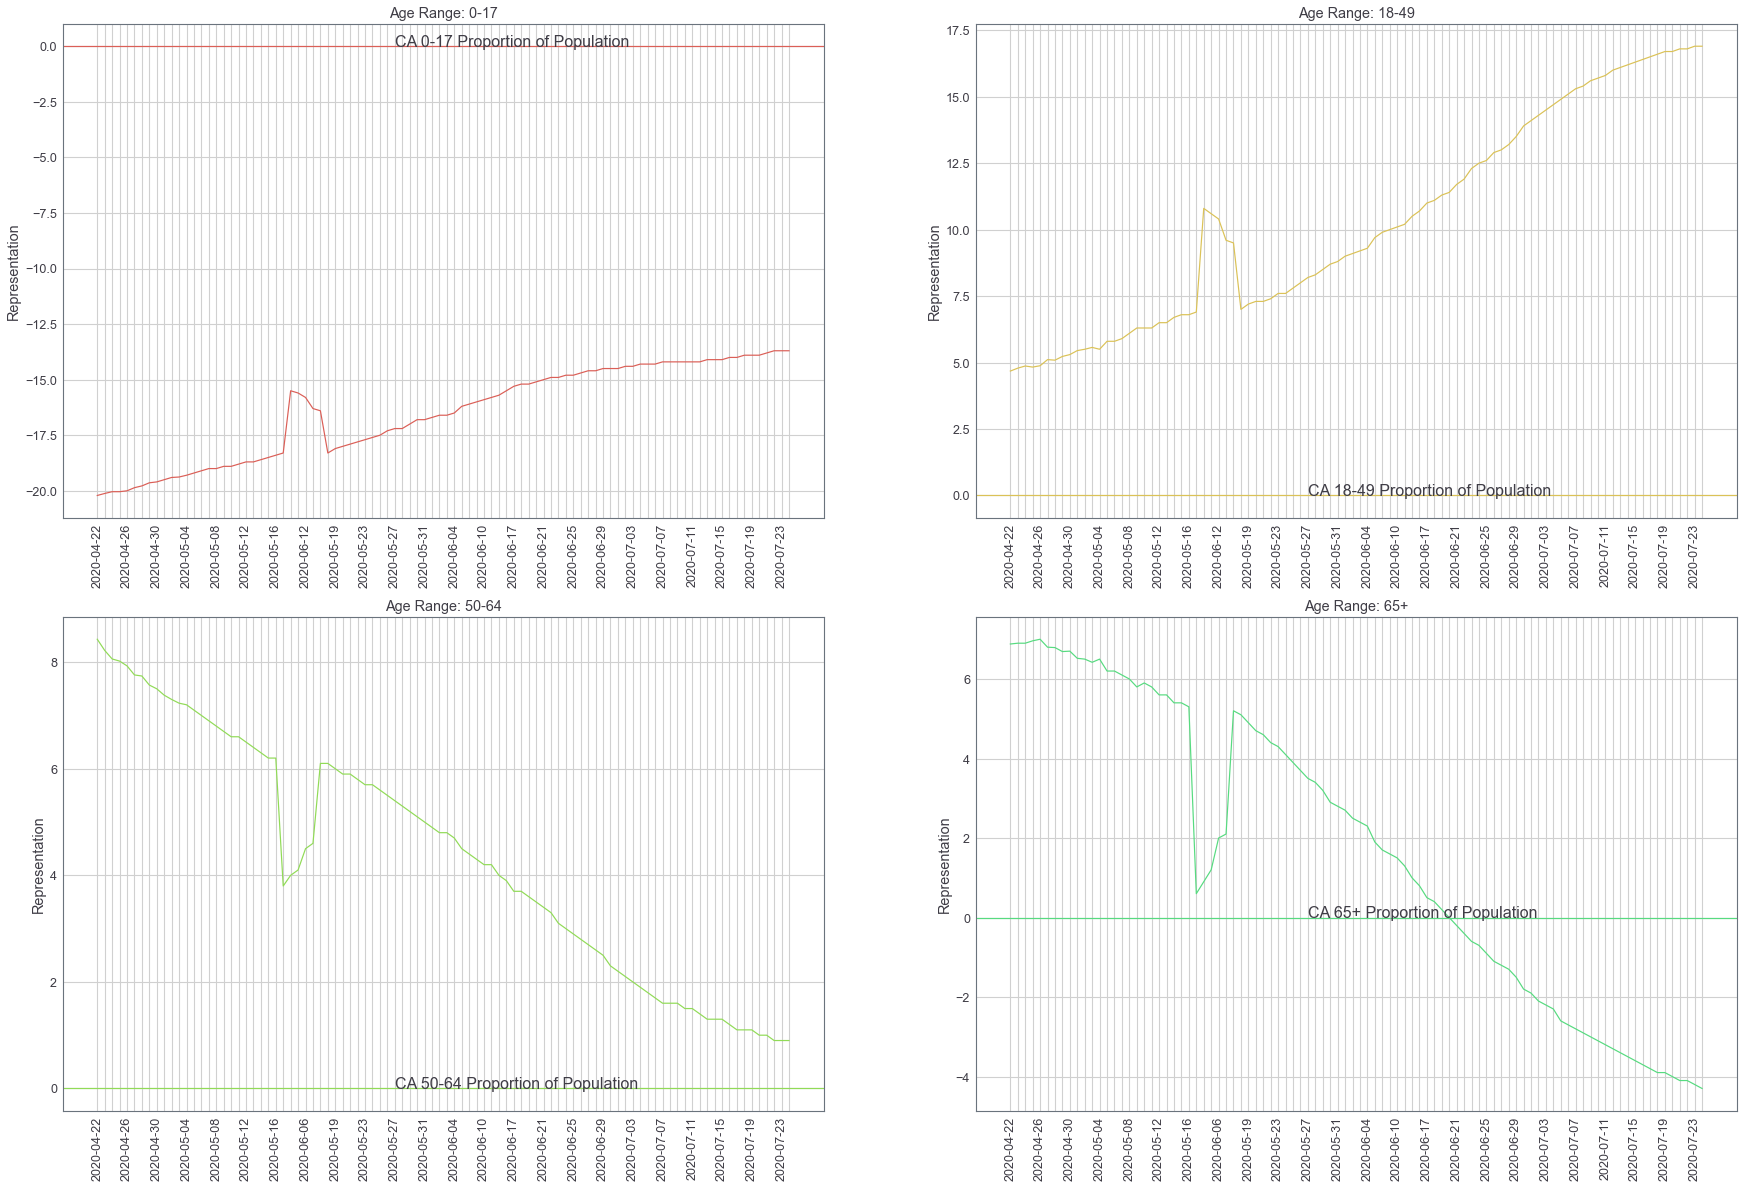

In [39]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(20)
fig.set_figwidth(30)

age_groups = [['0-17','18-49'],['50-64','65+']]
colors = [['#db5f57','#dbc257'],['#91db57','#57db80']]
lines = [[22.5, 43.5],[18.4, 15.59]]

for i in range(2):
    for j in range(2):
        ax[i,j].plot(filtered_age[filtered_age['age_group'] == age_groups[i][j]]['date'], filtered_age[filtered_age['age_group'] == age_groups[i][j]].case_percent - lines[i][j], color = colors[i][j])
        ax[i,j].set_title(f'Age Range: {age_groups[i][j]}')
        ax[i,j].set_ylabel('Representation')
        ax[i,j].axhline(y = 0, color = colors[i][j])
        ax[i,j].text(40, 0, f'CA {age_groups[i][j]} Proportion of Population', fontsize=16)
        
        plt.setp(ax[i,j].xaxis.get_majorticklabels(), rotation=90)
        
        reduce_ticks(ax[i,j])

plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

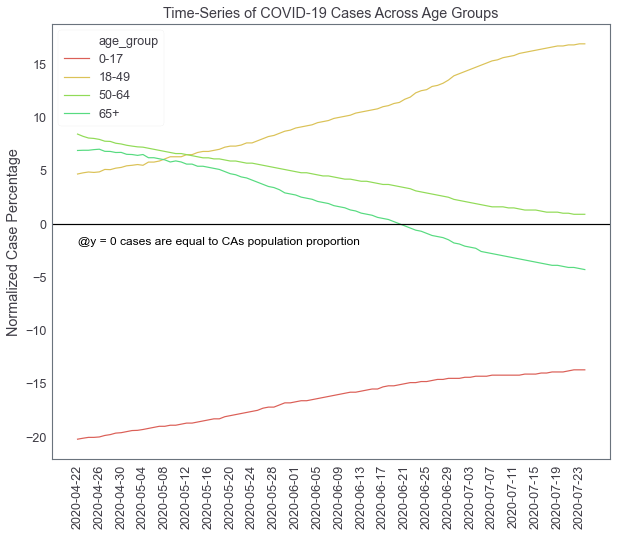

In [206]:
plt.clf()
fig = plt.figure()

sns.set_palette(sns.color_palette("hls", 8))
fig = plt.figure(figsize = [10,8])
ax = sns.lineplot(x = 'date', y = 'case_percent_normalized', hue = 'age_group', data = filtered_age)
ax.axhline(y = 0, c = 'Black')
ax.text(0, -2, f'@y = 0 cases are equal to CAs population proportion', fontsize=12, color = 'Black')

plt.xticks(rotation = 90)
plt.ylabel('Normalized Case Percentage')
plt.xlabel('')
plt.title('Time-Series of COVID-19 Cases Across Age Groups')
ax.grid(False)
reduce_ticks(ax)
#plt.legend(bbox_to_anchor=(1.05, 1))
#plt.gcf().subplots_adjust(right = 0.1)
        
plt.savefig('covid_age.png')
plt.show()

# Is Los Angeles Ready For the Uptick In Cases?

In [41]:
hospitals.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Stanislaus,2020-03-29T00:00:00,20.0,48.0,NaN,NaN,9.0,8.0,25.0
1,Monterey,2020-03-29T00:00:00,2.0,16.0,NaN,NaN,1.0,2.0,10.0
2,Madera,2020-03-29T00:00:00,1.0,6.0,NaN,NaN,1.0,1.0,8.0
3,San Benito,2020-03-29T00:00:00,1.0,1.0,NaN,NaN,1.0,0.0,1.0
4,Trinity,2020-03-29T00:00:00,0.0,0.0,NaN,NaN,0.0,0.0,NaN


In [42]:
hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6997 entries, 0 to 6996
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   county                                 6997 non-null   object 
 1   todays_date                            6997 non-null   object 
 2   hospitalized_covid_confirmed_patients  6989 non-null   float64
 3   hospitalized_suspected_covid_patients  6989 non-null   float64
 4   hospitalized_covid_patients            5712 non-null   float64
 5   all_hospital_beds                      5622 non-null   float64
 6   icu_covid_confirmed_patients           6968 non-null   float64
 7   icu_suspected_covid_patients           6968 non-null   float64
 8   icu_available_beds                     6193 non-null   float64
dtypes: float64(7), object(2)
memory usage: 492.1+ KB


In [43]:
hospitals.describe()

,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
count,6989.000000,6989.000000,5712.000000,5622.000000,6968.000000,6968.000000,6193.000000
mean,72.122335,28.675204,102.520833,1372.183209,23.548651,4.908869,69.877119
std,237.637491,93.767421,327.254863,3257.048269,73.192515,15.587813,173.918635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-110.000000
25%,0.000000,0.000000,1.000000,84.000000,0.000000,0.000000,4.000000
50%,5.000000,3.000000,9.000000,392.000000,2.000000,0.000000,14.000000
75%,42.000000,20.000000,66.000000,1347.000000,14.000000,3.000000,70.000000
max,2232.000000,1350.000000,2907.000000,23989.000000,625.000000,244.000000,1502.000000


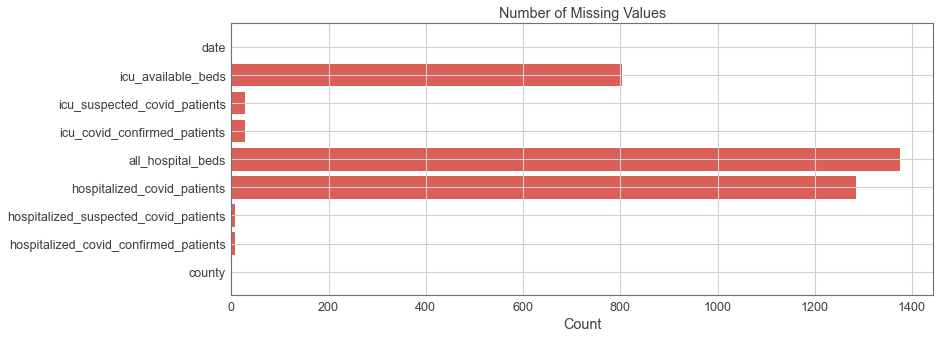

In [127]:
plt.figure(figsize = [15,5])
plt.barh(y = hospitals.columns, width = hospitals.isna().sum().values)
plt.gcf().subplots_adjust(left=0.25)
plt.title('Number of Missing Values')
plt.xlabel('Count')
plt.savefig('hospital_sanitycheck0')

In [45]:
hospitals.dtypes

county                                    object
todays_date                               object
hospitalized_covid_confirmed_patients    float64
hospitalized_suspected_covid_patients    float64
hospitalized_covid_patients              float64
all_hospital_beds                        float64
icu_covid_confirmed_patients             float64
icu_suspected_covid_patients             float64
icu_available_beds                       float64
dtype: object

In [46]:
hospitals['date'] = pd.to_datetime(hospitals.todays_date)

In [47]:
hospitals.drop('todays_date', axis = 1, inplace = True)

In [48]:
hospitals.head()

,county,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds,date
0,Stanislaus,20.0,48.0,NaN,NaN,9.0,8.0,25.0,2020-03-29
1,Monterey,2.0,16.0,NaN,NaN,1.0,2.0,10.0,2020-03-29
2,Madera,1.0,6.0,NaN,NaN,1.0,1.0,8.0,2020-03-29
3,San Benito,1.0,1.0,NaN,NaN,1.0,0.0,1.0,2020-03-29
4,Trinity,0.0,0.0,NaN,NaN,0.0,0.0,NaN,2020-03-29


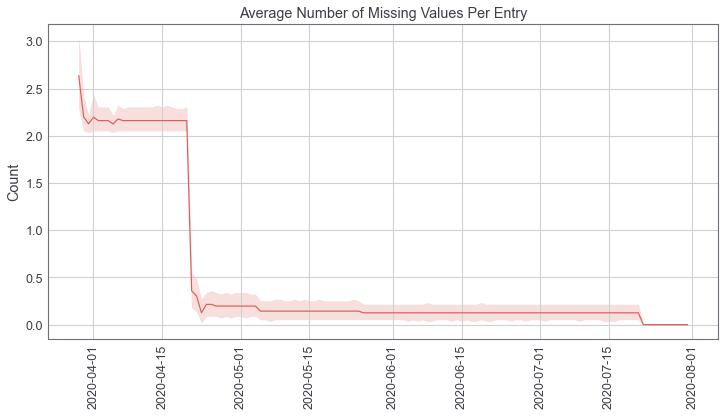

In [132]:
# Location of Missing Values
fig, ax = plt.subplots(figsize = [12,6])
ax = sns.lineplot(x = 'date', y = hospitals.isna().sum(axis = 1), data = hospitals)
plt.xticks(rotation = 90)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel('')
plt.title('Average Number of Missing Values Per Entry')
plt.ylabel('Count')
plt.savefig('hospital_sanitycheck1')
plt.show()

The number of missing values is spread evenly across the dates, no further cleaning is required at the moment.

# Los Angeles

In [50]:
hosp_LA = hospitals[hospitals.county == 'Los Angeles']

In [51]:
hosp_LA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 50 to 6979
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   county                                 125 non-null    object        
 1   hospitalized_covid_confirmed_patients  125 non-null    float64       
 2   hospitalized_suspected_covid_patients  125 non-null    float64       
 3   hospitalized_covid_patients            102 non-null    float64       
 4   all_hospital_beds                      102 non-null    float64       
 5   icu_covid_confirmed_patients           125 non-null    float64       
 6   icu_suspected_covid_patients           125 non-null    float64       
 7   icu_available_beds                     125 non-null    float64       
 8   date                                   125 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 9.8+ K

In [52]:
ppe_LA = ppe[ppe.county == 'Los Angeles']

In [53]:
beds_LA = bed_surge[bed_surge.county == 'Los Angeles']

In [54]:
cases_LA = cases[cases.county == 'Los Angeles']

In [55]:
cases_LA['date'] = pd.to_datetime(cases_LA.date)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
testing['date'] = pd.to_datetime(testing['date'])

In [57]:
beds_by_date = beds_LA.groupby(['date']).sum().reset_index()

## Is LA ready for the uptick in cases?

In [58]:
hosp_testing = testing.merge(hospitals.groupby('date').sum(), on = 'date', how = 'outer')

In [60]:
hosp_testing.head(2)

,date,tested,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
11,2020-03-29,27251,1306.0,2739.0,0.0,0.0,544.0,474.0,2423.0
12,2020-03-30,28704,1624.0,3528.0,0.0,0.0,662.0,594.0,2937.0


(array([737516., 737530., 737546., 737560., 737577., 737591., 737607.,
        737621., 737638.]),
 <a list of 9 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

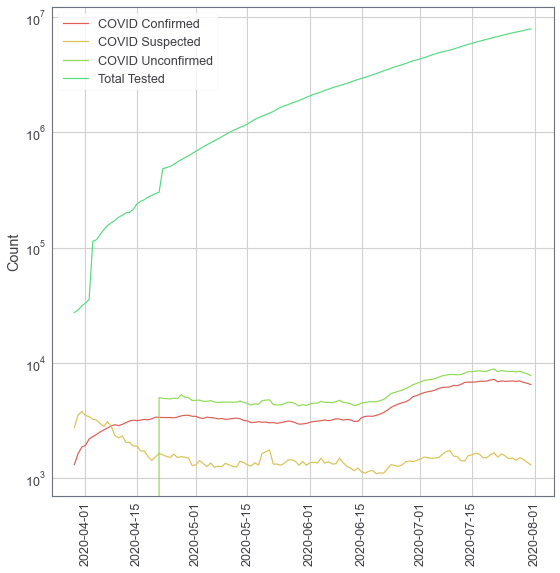

In [61]:
plt.clf()
plt.figure(figsize = [9,9])
sns.lineplot(x = 'date', y = 'hospitalized_covid_confirmed_patients', data = hosp_testing, label = 'COVID Confirmed')
sns.lineplot(x = 'date', y = 'hospitalized_suspected_covid_patients', data = hosp_testing, label = 'COVID Suspected')
sns.lineplot(x = 'date', y = 'hospitalized_covid_patients', data = hosp_testing, label = 'COVID Unconfirmed')
sns.lineplot(x = 'date', y = 'tested', data = hosp_testing, label = 'Total Tested')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation = 90)

In [93]:
hosp_testing['tests_per_day'] = hosp_testing.tested.diff()

In [94]:
remove_min = hosp_testing.drop(hosp_testing[hosp_testing.tests_per_day == hosp_testing.tests_per_day.min()].index)

In [95]:
remove_max = remove_min.drop(remove_min[remove_min.tests_per_day == remove_min.tests_per_day.max()].index)

In [96]:
hosp_testing = remove_max

In [97]:
hosp_testing.dropna(inplace=True)

In [98]:
hosp_testing.sort_values(by = 'date')

,date,tested,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds,percent_covid,tests_per_day
13,2020-03-31,31038,1855.0,3773.0,0.0,0.0,774.0,642.0,2745.0,18.132612,2334.0
14,2020-04-01,32944,1916.0,3478.0,0.0,0.0,810.0,617.0,2772.0,16.373239,1906.0
15,2020-04-02,35267,2176.0,3408.0,0.0,0.0,896.0,582.0,2720.0,15.833499,2323.0
16,2020-04-03,113687,2285.0,3227.0,0.0,0.0,1003.0,583.0,2910.0,4.848400,78420.0
17,2020-04-04,116563,2383.0,3183.0,0.0,0.0,1035.0,559.0,2951.0,4.775100,2876.0
...,...,...,...,...,...,...,...,...,...,...,...
131,2020-07-27,7417866,6896.0,1421.0,8317.0,66080.0,1975.0,223.0,2846.0,0.112121,121288.0
132,2020-07-28,7517466,6939.0,1500.0,8439.0,68595.0,2012.0,197.0,2711.0,0.112259,99600.0
133,2020-07-29,7633840,6753.0,1445.0,8198.0,69222.0,2029.0,191.0,2548.0,0.107390,116374.0
134,2020-07-30,7811041,6632.0,1367.0,7999.0,68708.0,2003.0,160.0,2487.0,0.102406,177201.0


In [99]:
hosp_testing['smoothed_tests_per_day'] = savgol_filter(hosp_testing.tests_per_day, 7, 2)

<Figure size 432x288 with 0 Axes>

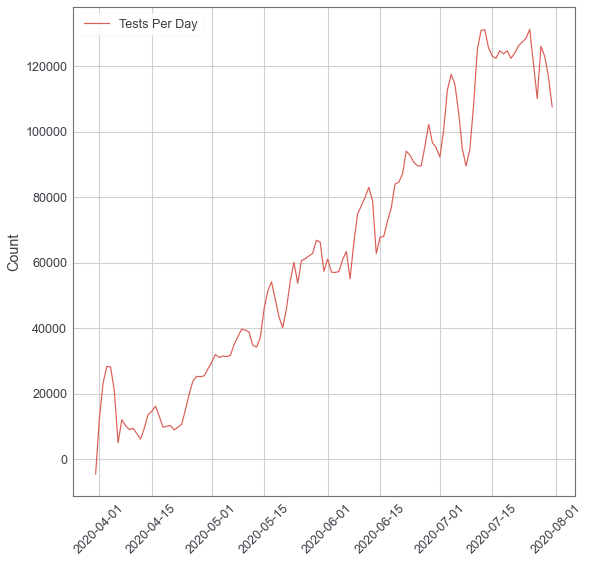

In [100]:
plt.clf()
plt.figure(figsize=(9,9))
sns.lineplot(x = 'date', y = 'smoothed_tests_per_day', data = hosp_testing, label = 'Tests Per Day')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

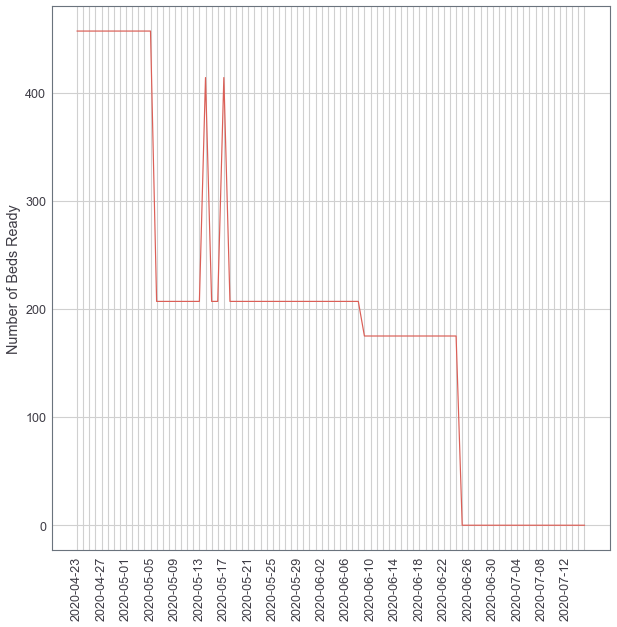

In [71]:
plt.figure(figsize = (10,10))
ax = sns.lineplot(y = 'beds_ready_to_accept_patients', x = 'date', data = beds_by_date)
plt.ylabel("Number of Beds Ready")
plt.xlabel('')
plt.xticks(rotation = 90)
reduce_ticks(ax)

(array([737516., 737530., 737546., 737560., 737577., 737591., 737607.,
        737621., 737638.]),
 <a list of 9 Text major ticklabel objects>)

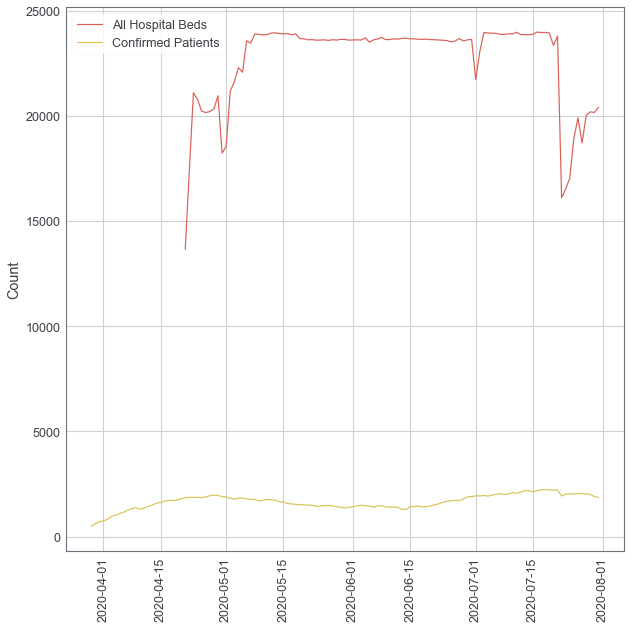

In [72]:
plt.figure(figsize = (10,10))
ax = sns.lineplot(y = 'all_hospital_beds', x = 'date', data = hosp_LA, label = 'All Hospital Beds')
sns.lineplot(y = 'hospitalized_covid_confirmed_patients', x = 'date', data = hosp_LA, label = 'Confirmed Patients')
plt.ylabel("Count")
plt.xlabel('')
plt.xticks(rotation = 90)

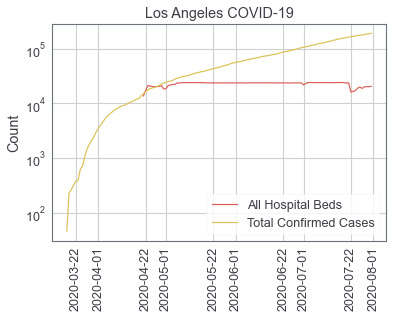

In [73]:
ax = sns.lineplot(x = 'date', y = 'all_hospital_beds', data = hosp_LA, label = 'All Hospital Beds')
sns.lineplot(x = 'date', y = 'totalcountconfirmed', data = cases_LA, label = 'Total Confirmed Cases')
plt.yscale('log')
plt.xticks(rotation = 90)
plt.title('Los Angeles COVID-19')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

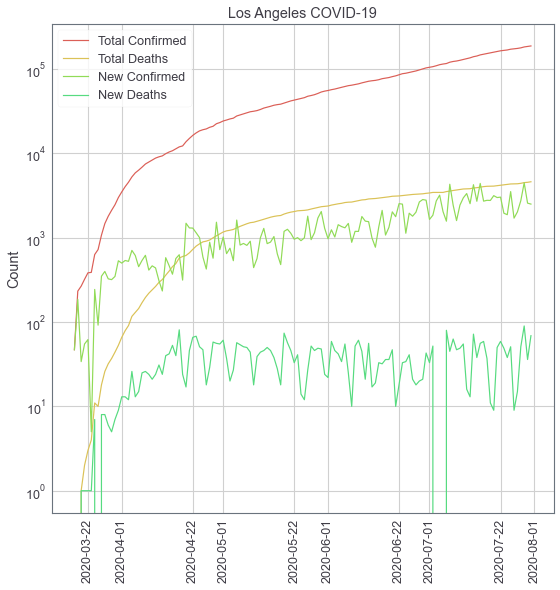

In [74]:
# What is the growth rate of the virus in LA
# Can we explain the dip in hospital beds?
plt.figure(figsize=(9,9))
ax = sns.lineplot(x = 'date', y = 'totalcountconfirmed', data = cases_LA, label = 'Total Confirmed')
sns.lineplot(x = 'date', y = 'totalcountdeaths', data = cases_LA, label = 'Total Deaths')
sns.lineplot(x = 'date', y = 'newcountconfirmed', data = cases_LA, label = 'New Confirmed')
sns.lineplot(x = 'date', y = 'newcountdeaths', data = cases_LA, label = 'New Deaths')
#sns.lineplot(x = 'date', y = 'tested', data = testing, label = 'Total Tested')
#sns.lineplot(y = 'all_hospital_beds', x = 'date', data = hosp_LA, label = 'All Hospital Beds')
#sns.lineplot(y = 'hospitalized_covid_confirmed_patients', x = 'date', data = hosp_LA, label = 'Confirmed Patients')
plt.yscale('log')
plt.xticks(rotation = 90)
plt.title('Los Angeles COVID-19')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Hospitalization Rate

In [75]:
# Confirmed / Number of patients in hospital
# Linear or logistic regression to see whether hospitals are likely to be overwhelmed
# Assumptions are that one patient per bed


In [76]:
cases.groupby('date').sum()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths
date,,,,
2020-03-18,675.0,15.0,675,15
2020-03-19,1006.0,18.0,331,3
2020-03-20,1224.0,22.0,218,4
2020-03-21,1468.0,26.0,244,4
2020-03-22,1733.0,35.0,265,9
...,...,...,...,...
2020-07-27,466550.0,8518.0,6000,73
2020-07-28,475305.0,8715.0,8755,197
2020-07-29,485502.0,8909.0,10197,194


In [77]:
hospitals.groupby('date').sum()

,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
date,,,,,,,
2020-03-29,1306.0,2739.0,0.0,0.0,544.0,474.0,2423.0
2020-03-30,1624.0,3528.0,0.0,0.0,662.0,594.0,2937.0
2020-03-31,1855.0,3773.0,0.0,0.0,774.0,642.0,2745.0
2020-04-01,1916.0,3478.0,0.0,0.0,810.0,617.0,2772.0
2020-04-02,2176.0,3408.0,0.0,0.0,896.0,582.0,2720.0
...,...,...,...,...,...,...,...
2020-07-27,6896.0,1421.0,8317.0,66080.0,1975.0,223.0,2846.0
2020-07-28,6939.0,1500.0,8439.0,68595.0,2012.0,197.0,2711.0
2020-07-29,6753.0,1445.0,8198.0,69222.0,2029.0,191.0,2548.0


In [78]:
cases['date'] = pd.to_datetime(cases.date)

In [79]:
cases_hospitals = hospitals.groupby('date').sum().reset_index().merge(cases.groupby('date').sum().reset_index(), on = 'date', how = 'outer')

In [80]:
cases_hospitals.sort_values(by='date')

,date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths
125,2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675.0,15.0,675,15
126,2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,18.0,331,3
127,2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224.0,22.0,218,4
128,2020-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1468.0,26.0,244,4
129,2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1733.0,35.0,265,9
...,...,...,...,...,...,...,...,...,...,...,...,...
120,2020-07-27,6896.0,1421.0,8317.0,66080.0,1975.0,223.0,2846.0,466550.0,8518.0,6000,73
121,2020-07-28,6939.0,1500.0,8439.0,68595.0,2012.0,197.0,2711.0,475305.0,8715.0,8755,197
122,2020-07-29,6753.0,1445.0,8198.0,69222.0,2029.0,191.0,2548.0,485502.0,8909.0,10197,194
123,2020-07-30,6632.0,1367.0,7999.0,68708.0,2003.0,160.0,2487.0,493588.0,9005.0,8086,96


In [81]:
cases_hospitals['percent_hospitalized'] = (cases_hospitals.hospitalized_covid_confirmed_patients + cases_hospitals.hospitalized_suspected_covid_patients + cases_hospitals.hospitalized_covid_patients + cases_hospitals.icu_covid_confirmed_patients + cases_hospitals.icu_suspected_covid_patients) / cases_hospitals.totalcountconfirmed * 100

In [82]:
cases_hospitals['percent_hospitalized'] = (cases_hospitals.hospitalized_covid_confirmed_patients + cases_hospitals.icu_covid_confirmed_patients) / cases_hospitals.totalcountconfirmed * 100

In [83]:
cases_hospitals['percent_ICU_hospitalized'] = (cases_hospitals.icu_covid_confirmed_patients) / cases_hospitals.totalcountconfirmed * 100

In [84]:
cases_hospitals['percent_covid_hospitalized'] = (cases_hospitals.hospitalized_covid_confirmed_patients) / cases_hospitals.totalcountconfirmed * 100

(array([737516., 737530., 737546., 737560., 737577., 737591., 737607.,
        737621., 737638.]),
 <a list of 9 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

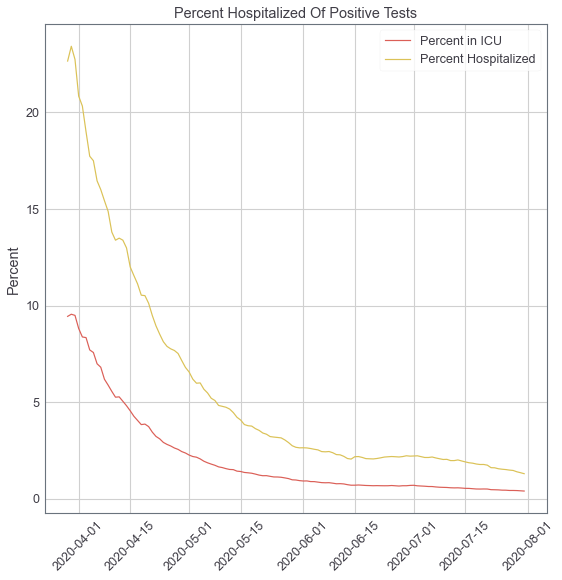

In [85]:
plt.clf()
plt.figure(figsize = [9,9])
sns.lineplot(x = 'date', y = 'percent_ICU_hospitalized', data = cases_hospitals, label = 'Percent in ICU')
sns.lineplot(x = 'date', y = 'percent_covid_hospitalized', data = cases_hospitals, label = 'Percent Hospitalized')
plt.xlabel('')
plt.ylabel('Percent')
plt.title('Percent Hospitalized Of Positive Tests')
plt.xticks(rotation = 45)

<Figure size 432x288 with 0 Axes>

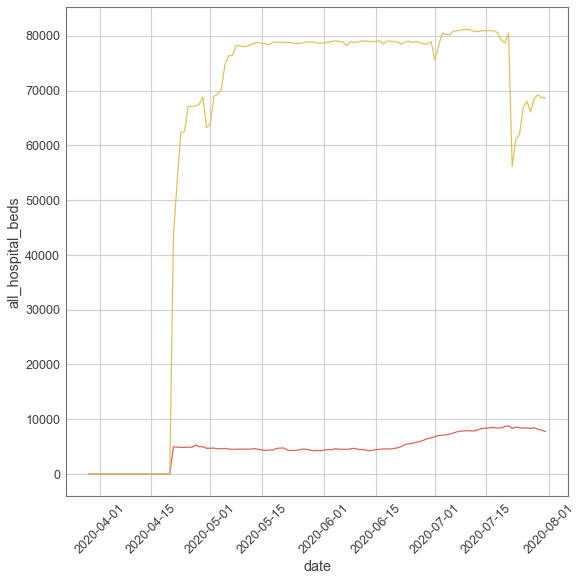

In [86]:
plt.clf()
plt.figure(figsize = [9,9])
sns.lineplot(x = 'date', y = 'hospitalized_covid_patients', data = cases_hospitals)
sns.lineplot(x = 'date', y = 'all_hospital_beds', data = cases_hospitals)
plt.xticks(rotation = 45)
plt.show()

In [87]:
cases_by_county = cases.groupby(['county','date']).sum()

In [88]:
hosp_by_county = hospitals.groupby(['county','date']).sum()

In [89]:
hosp_by_county.loc['Los Angeles']

,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
date,,,,,,,
2020-03-29,489.0,1132.0,0.0,0.0,191.0,182.0,345.0
2020-03-30,601.0,1277.0,0.0,0.0,245.0,244.0,456.0
2020-03-31,713.0,1239.0,0.0,0.0,315.0,239.0,445.0
2020-04-01,739.0,1332.0,0.0,0.0,335.0,220.0,492.0
2020-04-02,818.0,1270.0,0.0,0.0,346.0,193.0,488.0
...,...,...,...,...,...,...,...
2020-07-27,2045.0,554.0,2599.0,18716.0,576.0,93.0,901.0
2020-07-28,2022.0,575.0,2597.0,20025.0,550.0,71.0,918.0
2020-07-29,2002.0,566.0,2568.0,20193.0,578.0,57.0,877.0


In [90]:
cases_hospitals_LA = hosp_by_county.loc['Los Angeles'].reset_index().merge(cases_by_county.loc['Los Angeles'].reset_index(), on = 'date', how = 'outer')

<Figure size 432x288 with 0 Axes>

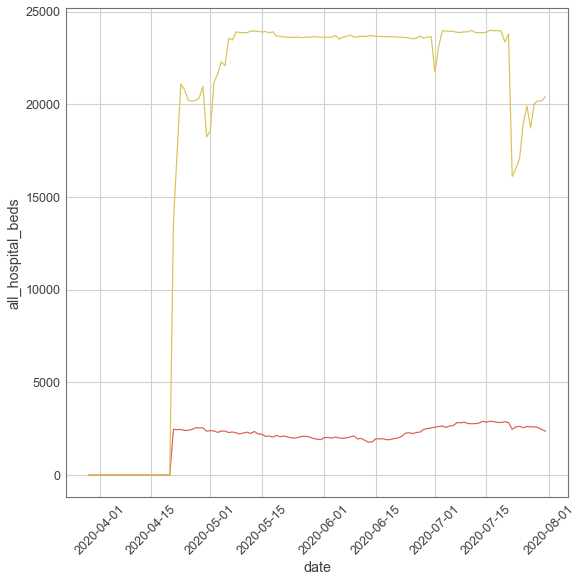

In [91]:
plt.clf()
plt.figure(figsize = [9,9])
sns.lineplot(x = 'date', y = 'hospitalized_covid_patients', data = cases_hospitals_LA)
sns.lineplot(x = 'date', y = 'all_hospital_beds', data = cases_hospitals_LA)
plt.xticks(rotation = 45)
plt.show()

(array([737506., 737516., 737537., 737546., 737567., 737577., 737598.,
        737607., 737628., 737638.]),
 <a list of 10 Text major ticklabel objects>)

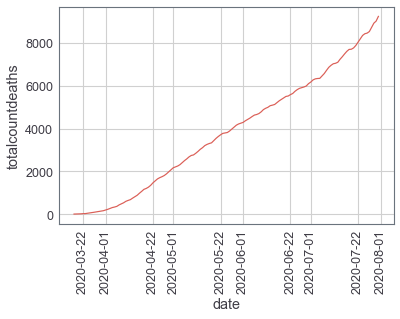

In [92]:
sns.lineplot(x = 'date', y = 'totalcountdeaths', data = cases_hospitals)
plt.xticks(rotation = 90)